# Sequential probability ratio test for permutations

## General Bernoulli SPRT

Suppose we observe independent, equiprobable events $X_1, X_2, \dots$, where $X_n$ is an indicator for whether the $n$th event occurred or not. Each indicator has a Bernoulli distribution with some probability $p$. We'd like to test the null hypothesis $H_0: p = p_0$ against the alternative $H_1: p = p_1 > p_0$. Wald's sequential probability ratio test (SPRT) is a hypothesis testing procedure, based on iteratively updating the likelihood ratio for the data after each observation, and reaching a decision once the likelihood ratio passes some threshold.

#### Procedure

Set $\mbox{LR}_0 \leftarrow 1$ and $j \leftarrow 0$.

 + Increment $j$
 + If $X_j = 1$, $\mbox{LR}_j \leftarrow \mbox{LR}_{j-1} \times p_1/p_0$. 
 + If $X_j = 0$, $\mbox{LR}_j \leftarrow \mbox{LR}_{j-1} \times (1-p_1)/(1- p_0)$.

Conclude $p > p_0$ (reject the null hypothesis) if 
$$\mbox{LR}_j  \ge \frac{1-\beta}{\alpha}.$$
Conclude $p \le p_0$ (fail to reject the null hypothesis) if
$$ \mbox{LR}_j  \le \frac{\beta}{1-\alpha}.$$
Otherwise, draw again.

#### Properties of the test

For any $\alpha \in (0, 1)$ and $\beta \in [0, 1)$, the sequential algorithm above tests the hypothesis $H_0$ at level no larger than $\alpha$ and with power at least $1-\beta$ against the alternative $H_1$.

In particular, Wald (1945) showed that if $H_0$ is true, then the probability is at most $\alpha$ that the likelihood ratio is ever greater than $1/\alpha$, no matter how many observations are made. If we set $\beta = 0$, then the likelihood ratio when we stop the test can be interpreted as a $p$-value.

The SPRT approximately minimizes the  expected sample size when $p \le p_0$ or $p > p_1$.
For values in $(p_1, p_0)$, it can have larger sample sizes than fixed-sample-size tests.

Analogous results follow if we specify the alternative $H_1: p_1 < p_0$ instead.

## Derangements

A derangement is a permutation that leaves no item fixed. For instance, if we permute the vector $(1, 2, 3, 4)$, then $(2, 3, 4, 1)$ is a derangement but $(1, 3, 4, 2)$ is not. We will base a SPRT on the frequency of derangements when we use a particular PRNG and sampling algorithm. If all permutations occur with equal frequency, then the probability that a permutation is a derangement is given by $p_0 = \frac{D_n}{n!}$, where $D_n$ is the number of derangements of $n$ items. To compute this probability under the null hypothesis, we need to count $D_n$.

Let $A_p$ denote the set of permutations of $n$ items that fix the $p$th item, for $p=1,\dots,n$. The set of derangements is the complement of the union of these sets, so $D_n = n! - \lvert \cup_{p=1}^n A_p \rvert$. Using the inclusion-exclusion principle, we have

\begin{align*}
\lvert \cup_{p=1}^n A_p \rvert &= \sum_{p=1}^n \lvert A_p \rvert - \sum_{p < q} \lvert A_p \cap A_q \rvert + \dots + (-1)^{n+1}\lvert \cap_{p=1}^n A_p \rvert \\
&= \text{# permutations fixing one item} - \text{# permutations fixing two items} + \dots + (-1)^{n+1} \text{ permutations fixing all items}
\end{align*}

The number of permutations fixing $p$ items is $(n-p)! {n \choose p}$ because after fixing $p$ points, we can freely permute $n-p$ of them, and there are ${n\choose p}$ subsets of $p$ points that we could fix. Plugging this back in, we get

\begin{align*}
D_n &= n! - (n-1)!{n \choose 1} + (n-2)!{n \choose 2} - \dots + (-1)^{n}{n \choose n} \\
\frac{D_n}{n!} &= 1 - \frac{1}{1!} + \frac{1}{2!} - \dots + \frac{(-1)^{n}}{n!} \\
&= \sum_{p=0}^n \frac{(-1)^{p}}{p!}
\end{align*}

This probability converges quickly to $e^{-1} \approx 0.3678794$, but differs somewhat for small $n$. We let $p_0 = \frac{D_n}{n!}$ and conduct the SPRT for whether derangements occur with this frequency.

## Simulation parameters

We compare three PRNGs (Mersenne Twister, Super Duper LCG, and SHA-256) and two permutation algorithms (permuting indices and the Fisher-Yates-Knuth-Durstenfeld shuffle). Throughout, we use a population of size $n=100$, for a total of $100! \approx 9.3 \times 10^{157}$ possible multinomial categories. We specify $p_1 = 1.01p_0$ to test the alternative hypothesis $p_1 > p_0$ and $p_1 = 0.99 p_0$ to test the alternative hypothesis $p_1 < p_0$. We use a type I error rate of $\alpha=0.025$ and type II error rate of $\beta = 0$; this ensures that we never accept the null hypothesis, but either reject it at level $\alpha$ or terminate after $10^6$ steps without making a decision.

## Summary of results

We tended to reject the null hypothesis around $5\%$ of the time for the three PRNGs when permuting indices, but the rejection rates for SD were higher than the $5\%$ nominal level. SD rejected both the lower and upper tailed alternatives more than $2.5\%$ of the time: it tended to generate too few and too many derangements more often than due to chance if its outputs were truly random uniform sequences.

The SPRT rejected the null hypothesis less often than $5\%$ of the time for MT and SHA-256. There is not evidence that they over- or under-produce derangements.

For the tests that were rejected, SD tended to require fewer steps to terminate than MT or SHA-256.

In [1]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(stringr)
options(warn = (-1), message = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c("pi", "fykd"))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_derangements_", combinations[index, 2], "_n100.csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE)
  return(tmp)
})
res <- do.call(rbind, res)

In [3]:
head(res)
str(res)

prng,algorithm,seed,decision_upper,LR_upper,steps_upper,decision_lower,LR_lower,steps_lower
MT,permute_indices,739828299,None,6.433666e-124,10000000,None,2.635278e-130,10000000
MT,permute_indices,3802979302,None,3.707149e-137,10000000,None,5.196453e-117,10000000
MT,permute_indices,2488119888,None,6.969507e-110,10000000,None,2.124658e-144,10000000
MT,permute_indices,2813529707,None,8.375097e-126,10000000,None,2.061549e-128,10000000
MT,permute_indices,564698376,None,1.312905e-115,10000000,None,1.191902e-138,10000000
MT,permute_indices,2114313936,None,1.460270e-110,10000000,None,1.020707e-143,10000000


'data.frame':	6000 obs. of  9 variables:
 $ prng          : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...
 $ algorithm     : Factor w/ 2 levels "permute_indices",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ seed          : num  7.40e+08 3.80e+09 2.49e+09 2.81e+09 5.65e+08 ...
 $ decision_upper: Factor w/ 2 levels "1","None": 2 2 2 2 2 2 2 2 2 2 ...
 $ LR_upper      : num  6.43e-124 3.71e-137 6.97e-110 8.38e-126 1.31e-115 ...
 $ steps_upper   : int  10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 ...
 $ decision_lower: Factor w/ 2 levels "1","None": 2 2 2 2 2 2 2 2 2 2 ...
 $ LR_lower      : num  2.64e-130 5.20e-117 2.12e-144 2.06e-128 1.19e-138 ...
 $ steps_lower   : int  10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 10000000 ...


In [4]:
tmp <- melt(res, id.vars = c("prng", "algorithm", "seed"))
splitCols <- str_split_fixed(tmp$variable, "_", 2)
colnames(splitCols) <- c("var", "alternative")
tmp <- cbind(tmp, splitCols)
res <- dcast(tmp, prng+algorithm+seed+alternative ~ var, value.var = "value")
str(res)

'data.frame':	12000 obs. of  7 variables:
 $ prng       : Factor w/ 3 levels "MT","SD","SHA256": 1 1 1 1 1 1 1 1 1 1 ...
 $ algorithm  : Factor w/ 2 levels "permute_indices",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ seed       : num  568546 568546 3371176 3371176 4324413 ...
 $ alternative: Factor w/ 2 levels "lower","upper": 1 2 1 2 1 2 1 2 1 2 ...
 $ decision   : chr  "None" "None" "None" "None" ...
 $ LR         : chr  "1.01011293901e-128" "1.70420200027e-125" "2.19821829479e-120" "8.48403537263e-134" ...
 $ steps      : chr  "10000000" "10000000" "10000000" "10000000" ...


In [8]:
print("Rejection rates, by alternative")
res %>% group_by(prng, algorithm, alternative) %>% summarise("Rejection rate" = mean(decision == "1"))

[1] "Rejection rates, by alternative"


prng,algorithm,alternative,Rejection rate
MT,permute_indices,lower,0.013
MT,permute_indices,upper,0.022
MT,fykd,lower,0.021
MT,fykd,upper,0.019
SD,permute_indices,lower,0.028
SD,permute_indices,upper,0.029
SD,fykd,lower,0.036
SD,fykd,upper,0.020
SHA256,permute_indices,lower,0.024
SHA256,permute_indices,upper,0.018


In [16]:
print("Rejection rates overall")
res %>% group_by(prng, algorithm) %>% 
    summarise("Rejection rate" = mean(decision == "1")*2)

[1] "Rejection rates overall"


prng,algorithm,Rejection rate
MT,permute_indices,0.035
MT,fykd,0.040
SD,permute_indices,0.057
SD,fykd,0.056
SHA256,permute_indices,0.042
SHA256,fykd,0.045


In [6]:
rejects <- res %>% filter(decision != "None")
rejects %>% group_by(prng, algorithm, alternative) %>% 
    mutate(steps = as.numeric(steps)) %>%
    summarise("Mean steps" = mean(steps),
    "Median steps" = median(steps),
    "Min steps" = min(steps),
    "Max steps" = max(steps))

prng,algorithm,alternative,Mean steps,Median steps,Min steps,Max steps
MT,permute_indices,lower,173495.85,111950.0,51702,765096
MT,permute_indices,upper,112334.41,111570.0,42887,220068
MT,fykd,lower,95413.71,73708.0,31873,320288
MT,fykd,upper,117164.95,79185.0,28738,374727
SD,permute_indices,lower,111313.46,104245.0,20790,265335
SD,permute_indices,upper,117369.48,112803.0,28379,365877
SD,fykd,lower,141638.17,106578.5,24472,869675
SD,fykd,upper,112887.55,97888.5,22355,254362
SHA256,permute_indices,lower,111385.29,104952.0,24314,306232
SHA256,permute_indices,upper,135819.39,127486.5,56253,401063


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


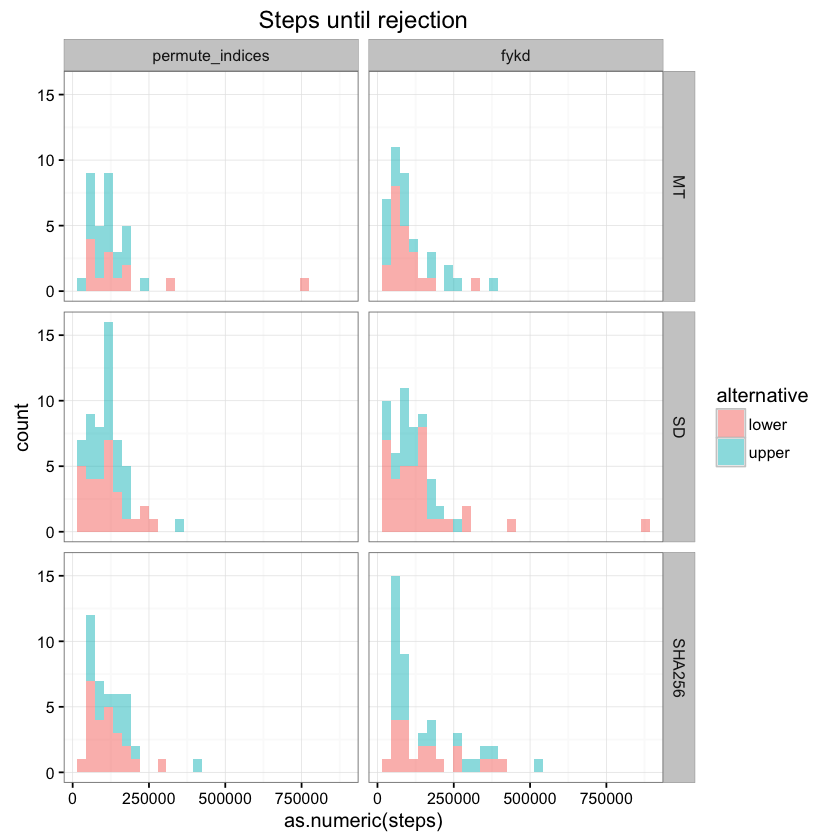

In [7]:
rejects %>% 
    ggplot(aes(as.numeric(steps), fill = alternative)) + 
    geom_histogram(alpha = 0.5) + 
    facet_grid(prng~algorithm) +
    ggtitle("Steps until rejection") +
    theme_bw()